In [1]:
import numpy as np

In [2]:
from imTools import *

In [3]:
# target = readImage('images/BrainProtonDensitySliceShifted13x17y.png', (100,100))
# base = readImage('images/BrainT1Slice.png', (100,100))
target = readImage('images/BrainProtonDensitySliceShifted13x17y.png', (50,50))
base = readImage('images/BrainT1Slice.png', (50,50))

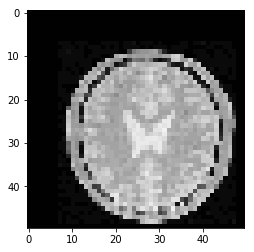

In [4]:
plt.imshow(target)
plt.show()

In [5]:
from Taylor08 import *

In [17]:
px = np.random.random(19)
py = np.random.random(19)

In [18]:
D = gaussianDeformImage(target, 10, 4, px, py)

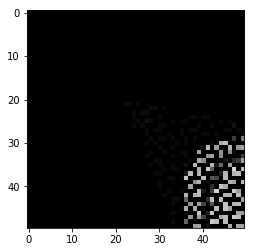

In [19]:
plt.imshow(D)
plt.show()

In [20]:
(dIm, Ax, Ay, Iz, b, Dx, Dy, C) = Taylor08(target, base, 10, px, py)

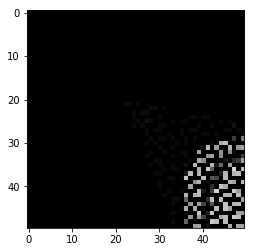

In [21]:
plt.imshow(dIm)
plt.show()

In [11]:
Ax.shape

(7849, 416)

In [22]:
z = np.random.random(len(b))
a = np.matmul(Ax, Dx) + np.matmul(Ay, Dy) - z

In [23]:
s = b - a

In [24]:
D1 = Ax.T@np.diag(s**(-2))@Ax
D2 = Ay.T@np.diag(s**(-2))@Ay

(559, 559)

In [40]:
Hpx = C.T@D1@C
Hpy = C.T@D2@C

In [45]:
(np.concatenate((Hpx, Hpy), axis=1)).shape

(19, 38)

In [ ]:
gpx = -1 * dx.T@s**(-1)
gpy = -1 * dy.T@s**(-1)
gz = -1 * dz.T@s**(-1)

In [52]:
b.shape

(10572,)